In [15]:
import nilearn.image as ni
import nibabel as nb
from nilearn.plotting import plot_anat, plot_prob_atlas, show, plot_stat_map
import SimpleITK as sitk
from utils import pad_nifti_image, multires_registration, interpolate_zeros
from aligner import Aligner
from warp_utils import apply_warp
import numpy as np
from monai.transforms import LoadImage, EnsureChannelFirst
from warper import Warper


# %matplotlib notebook
# import gui


In [16]:
sub_bse_t2 = "data/test_case/F2_BC.bfc.nii.gz"
sub_mask_t2 = "data/test_case/MAC10.mask.nii.gz"

atlas_bse_t2 = "/deneb_disk/RodentTools/data/MSA100/MSA100/MSA100.bfc.nii.gz"
atlas_labels = "/deneb_disk/RodentTools/data/MSA100/MSA100/MSA100.label.nii.gz"

centered_atlas = "data/test_case/atlas.cert.nii.gz"
centered_atlas_labels = "data/test_case/atlas.cert.label.nii.gz"

centered_atlas_linreg = "data/test_case/atlas.lin.nii.gz"
centered_atlas_linreg_labels = "data/test_case/atlas.lin.label.nii.gz"
lin_reg_map_file = "data/test_case/lin_ddf.nii.gz"


In [17]:

nonlin_reg_map_file = "data/test_case/nonlin_ddf.nii.gz"
centered_atlas_nonlinreg = "data/test_case/atlas.nonlin.nii.gz"
centered_atlas_nonlinreg_labels = "data/test_case/atlas.nonlin.label.nii.gz"
jac_det_file = "data/test_case/jacobian_det.nii.gz"


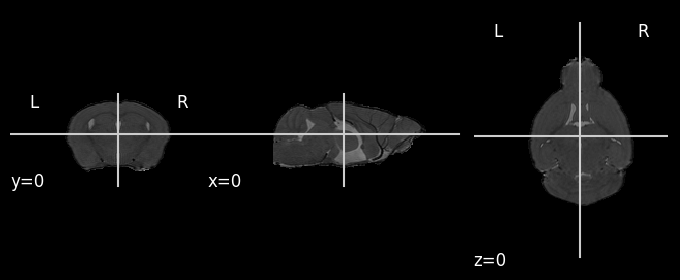

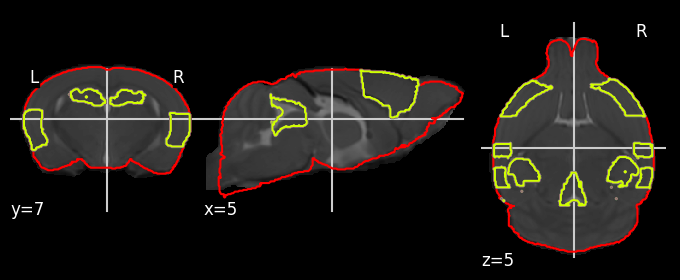

In [18]:

plot_anat(sub_bse_t2)
d = plot_anat(atlas_bse_t2)
d.add_contours(atlas_labels, cmap="prism")


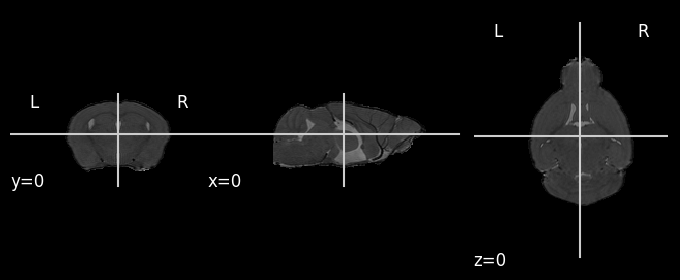

In [19]:
plot_anat(sub_bse_t2)


Final metric value: -0.649893214487583
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 10.


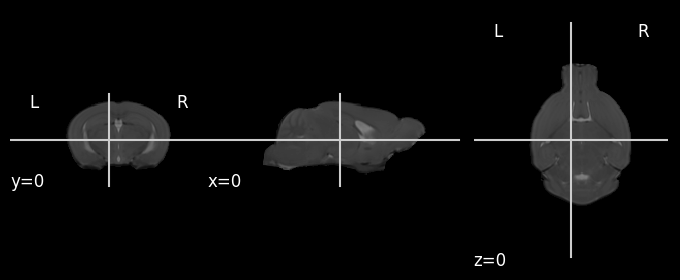

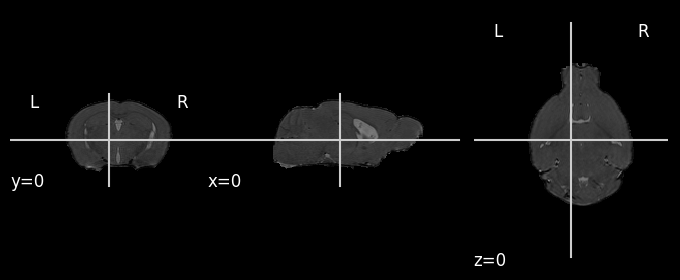

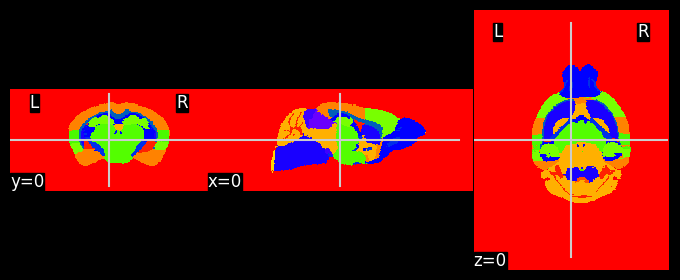

In [20]:
fixed_image = sitk.ReadImage(sub_bse_t2, sitk.sitkFloat32)
moving_image = sitk.ReadImage(atlas_bse_t2, sitk.sitkFloat32)
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

final_transform, _ = multires_registration(
    fixed_image, moving_image, initial_transform)

moved_image = sitk.Resample(moving_image, fixed_image, final_transform)

sitk.WriteImage(moved_image, centered_atlas)

moving_image = sitk.ReadImage(atlas_labels, sitk.sitkUInt16)
moved_image = sitk.Resample(
    moving_image,
    fixed_image,
    transform=final_transform,
    interpolator=sitk.sitkNearestNeighbor,
)
sitk.WriteImage(moved_image, centered_atlas_labels)


plot_anat(centered_atlas, cut_coords=(0, 0, 0))
plot_anat(sub_bse_t2, cut_coords=(0, 0, 0))
plot_anat(centered_atlas_labels, cut_coords=(0, 0, 0),cmap='prism')

show()


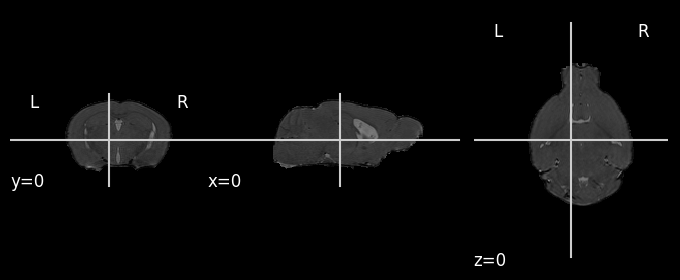

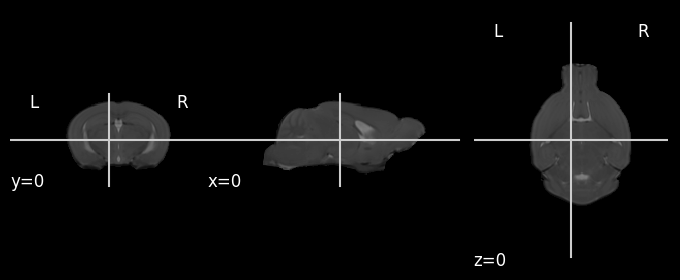

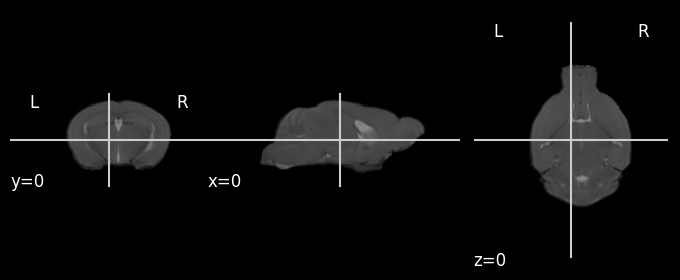

In [21]:
aligner = Aligner()
aligner.affine_reg(
    fixed_file=sub_bse_t2,
    moving_file=centered_atlas,
    output_file=centered_atlas_linreg,
    ddf_file=lin_reg_map_file,
    loss="cc",
)

plot_anat(sub_bse_t2, cut_coords=(0, 0, 0))
plot_anat(centered_atlas, cut_coords=(0, 0, 0))
plot_anat(centered_atlas_linreg, cut_coords=(0, 0, 0))


In [22]:
disp_field, meta = LoadImage()(lin_reg_map_file)
disp_field = EnsureChannelFirst()(disp_field)
print(disp_field.shape)

at1, meta = LoadImage()(centered_atlas_labels)
at_lab = EnsureChannelFirst()(at1)
print(at_lab.shape)

warped_lab = apply_warp(
    disp_field[None,], at_lab[None,], at_lab[None,], interp_mode="nearest"
)
nb.save(
    nb.Nifti1Image(warped_lab[0, 0].detach().cpu().numpy(), at_lab.affine),
    centered_atlas_linreg_labels,
)


torch.Size([3, 192, 256, 100])
torch.Size([1, 192, 256, 100])


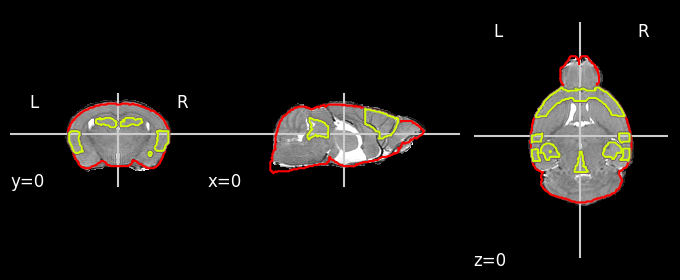

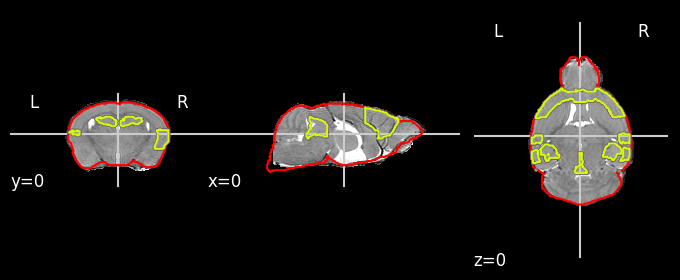

In [23]:
d = plot_anat(sub_bse_t2,vmax=12000)
d.add_contours(centered_atlas_labels, cmap="prism")
d = plot_anat(sub_bse_t2, vmax=12000)
d.add_contours(centered_atlas_linreg_labels, cmap="prism")


In [24]:
nonlin_reg = Warper()
nonlin_reg.nonlinear_reg(
    target_file=sub_bse_t2,
    moving_file=centered_atlas_linreg,
    output_file=centered_atlas_nonlinreg,
    ddf_file=nonlin_reg_map_file,
    reg_penalty=1,
    nn_input_size=64,
    lr=1e-4,
    max_epochs=5000,
    loss="cc",
    jacobian_determinant_file=jac_det_file,
)


optimizing
finished  5000  epochs93m -0.08  



computing deformation field
applying warp
saving warped output: data/test_case/atlas.nonlin.nii.gz
saving ddf: data/test_case/nonlin_ddf.nii.gz


In [25]:
disp_field, meta = LoadImage()(nonlin_reg_map_file)
disp_field = EnsureChannelFirst()(disp_field)
print(disp_field.shape)

at1, meta = LoadImage()(centered_atlas_linreg_labels)
at_lab = EnsureChannelFirst()(at1)
print(at_lab.shape)

warped_lab = apply_warp(
    disp_field[None,], at_lab[None,], at_lab[None,], interp_mode="nearest"
)
nb.save(
    nb.Nifti1Image(
        np.uint16(warped_lab[0, 0].detach().cpu().numpy()), at_lab.affine),
    centered_atlas_nonlinreg_labels,
)


torch.Size([3, 192, 256, 100])
torch.Size([1, 192, 256, 100])


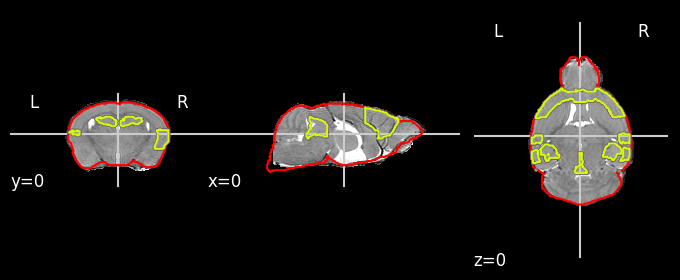

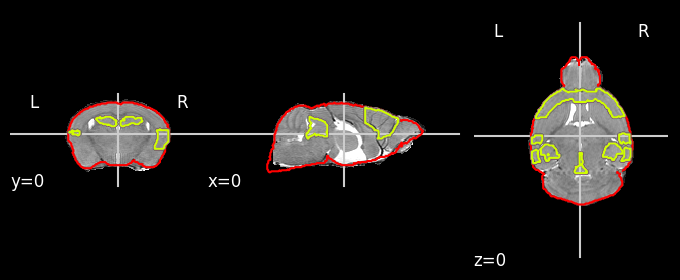

In [30]:
d = plot_anat(sub_bse_t2,vmax=12000)
d.add_contours(centered_atlas_linreg_labels, cmap="prism")
d = plot_anat(sub_bse_t2,vmax=12000)
d.add_contours(centered_atlas_nonlinreg_labels, cmap="prism")


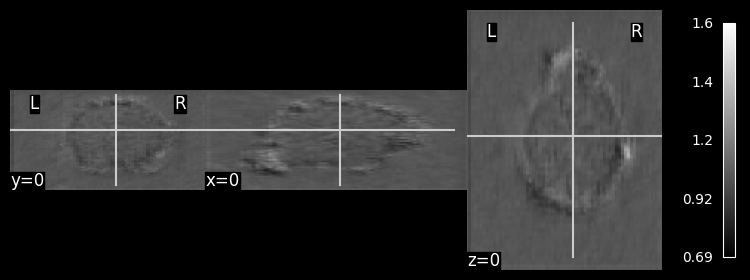

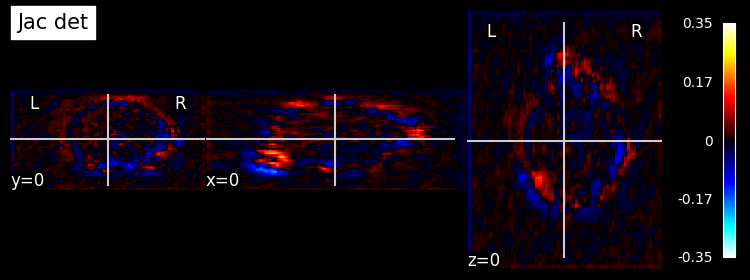

In [27]:
plot_anat(jac_det_file, colorbar=True)

jac=nb.load(jac_det_file)
jac = jac.get_fdata() - 1

from nilearn.image import new_img_like
jac = new_img_like(sub_bse_t2,jac)
plot_stat_map(jac,sub_bse_t2,title='Jac det')